In [2]:
import sys

print(sys.executable)

C:\ProgramData\Miniconda3\envs\cd-python-tcc\python.exe


In [30]:
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline 
import numpy as np
import pandas as pd
import os
import seaborn as sns

In [20]:
df_wind = pd.read_excel(r'D:\Bibliotecas\Documents\Poli\TCC\Programa\Energy_consumption_forecasting\Data\Weather_data\treated\wind.xls'
                        , index_col='date'
                        , parse_dates = ['date'])

df_wind.head(20)

,wind_vel,wind_dir
date,,
2006-01-01 00:00:00,14.0,NW
2006-01-01 01:00:00,6.0,NW
2006-01-01 02:00:00,4.0,NW
2006-01-01 03:00:00,3.0,N
2006-01-01 04:00:00,6.0,N
2006-01-01 05:00:00,2.0,N
2006-01-01 06:00:00,9.0,N
2006-01-01 07:00:00,8.0,NNW
2006-01-01 08:00:00,12.0,NNW


In [21]:
df_wind.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26304 entries, 2006-01-01 00:00:00 to 2008-12-31 23:00:00
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   wind_vel  26304 non-null  float64
 1   wind_dir  26304 non-null  object 
dtypes: float64(1), object(1)
memory usage: 616.5+ KB


In [22]:
df_wind.describe()

,wind_vel
count,26304.000000
mean,6.099795
std,3.596556
min,0.000000
25%,3.000000
50%,6.000000
75%,8.000000
max,23.000000


<AxesSubplot:xlabel='date'>

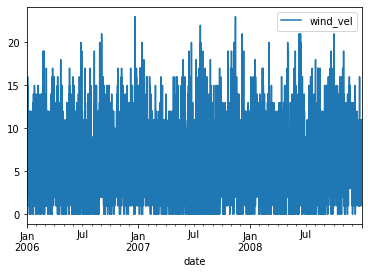

In [27]:
df_wind.plot()

<BarContainer object of 36 artists>

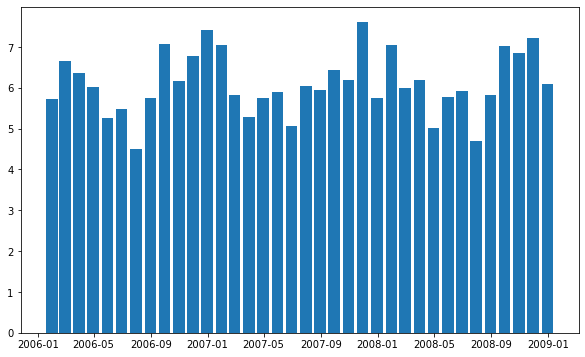

In [37]:
# Plotting the mean of the wind_velocity each month
df_month = df_wind.resample("M").mean()

# Setting the plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.bar(df_month.index, df_month.loc[:,'wind_vel'], width=25, align='center')